
# MONTHLY SALES FORECASTING MODEL

## Introduction

Prediction and forecasting on time based data is known as Time Series Modeling. It basically involves working with data that is time based (hour, date, months, years etc) in order to derive insights from the data.

"Time series is a series of data points indexed (or listed or graphed) in time order."
It is extremely common for companies to use time series in order to analyse data regarding sales for the next week, month or perhaps next year.

### Concepts

An important aspect of any time series is STATIONARITY.

There are three basic criteria for any time series to classified as stationary:

~ The mean of the series should not be a function of time rather should be a constant.
<img src = 'https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Mean_nonstationary.png'>

~ The variance of the series should not a be a function of time.

<img src = '/home/prerna/ShepHertz/PYTHON/Var_nonstationary.webp'>

~ The covariance of the i th term and the (i + m) th term should not be a function of time.
<img src = 'Cov_nonstationary.webp'>

The importance of a time series being stationary is that until the series be stationary we cannot build a time series model. In cases where the series is not stationary, we must stationarise it first in order to move forward.
To sum it up, in order for a time series to be stationary it's statistical properties must remain constant with time

Let's import some libraries. First, we will need the [statsmodels](http://statsmodels.sourceforge.net/stable/) library, which has many statistical modeling functions, including time series. You need to install it before building the time series model.

In [154]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

from sklearn.metrics import mean_squared_error   # for calculating error 

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

## Data

The data was initially on daily basis, it has now been resampled by month. Pandas has dedicated libraries for handling TS objects, it allows us to parse columns as dates. It also enables us to change the index to any given column as well.

parse_dates: This specifies the column which contains the date-time information. As we say above, the column name is ‘BillingDate’.

index_col: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘BillingDate’ column as index.


This data frame has been indexed by 'BillingDate' in the following case and only the 'NetValue' column has been retained.

In [155]:
data = pd.read_csv("ABC.csv", parse_dates=['BillingDate'], index_col='BillingDate')
data = data[['NetValue']]

In [156]:
data.head()

,NetValue
BillingDate,
2016-01-31,4804483.6000
2016-02-29,7395656.1800
2016-03-31,9157127.6300
2016-04-30,6462020.8700
2016-05-31,6058978.0500


Now we can see that the data has time object as index and #NetValue as the column. We can cross-check the datatype of the index with the following command:



In [157]:
data.index

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='BillingDate', freq=None)

# Move, smoothe, evaluate


Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [158]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(data, 2) # prediction for the last observed day (past 24 hours)

5937401.355

Moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [159]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Let's smooth by the previous 2 months.

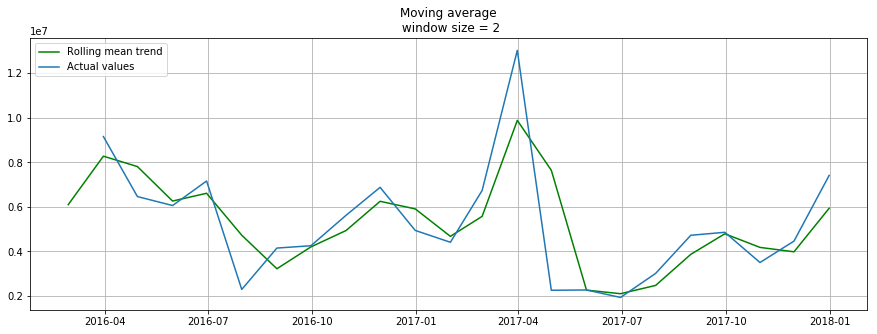

In [160]:
plotMovingAverage(data, 2) 

Now let's try smoothing by the previous 12 months.

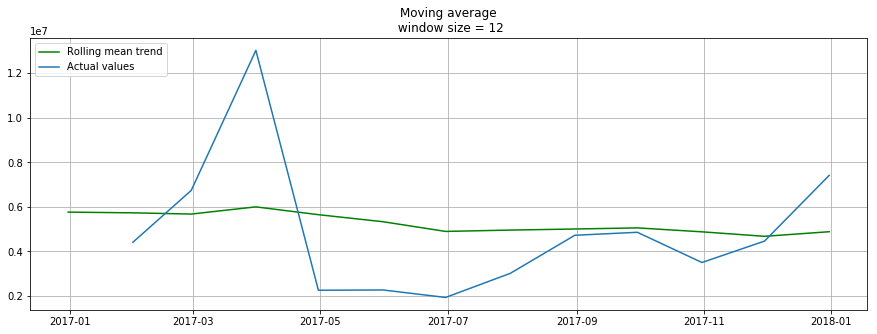

In [161]:
plotMovingAverage(data, 12) 

We can also plot confidence intervals for our smoothed values. The upper and lower bounds mark the region beyond which anomalies lie

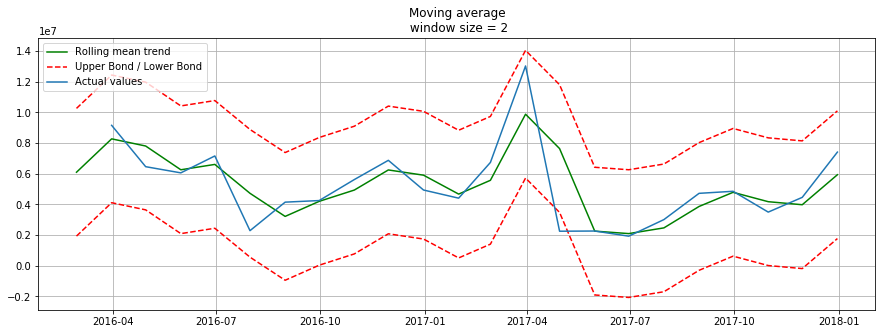

In [162]:
plotMovingAverage(data, 2, plot_intervals=True)

Let's find out the anomalies in the data

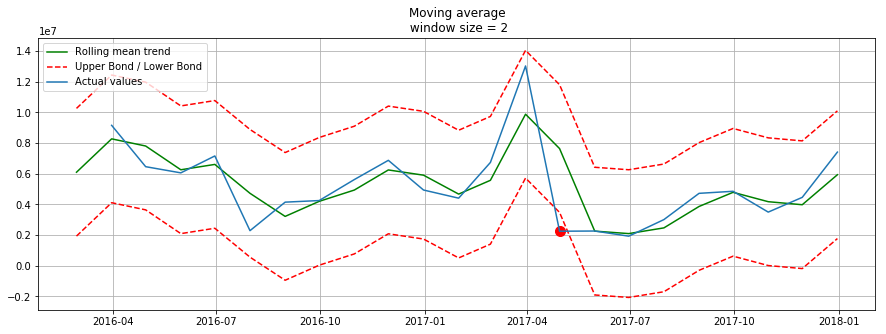

In [163]:
plotMovingAverage(data, 2, plot_intervals=True, plot_anomalies=True)

## How to Check Stationarity of a Time Series?

Most time series models work on the assumption that the given time series is stationary.

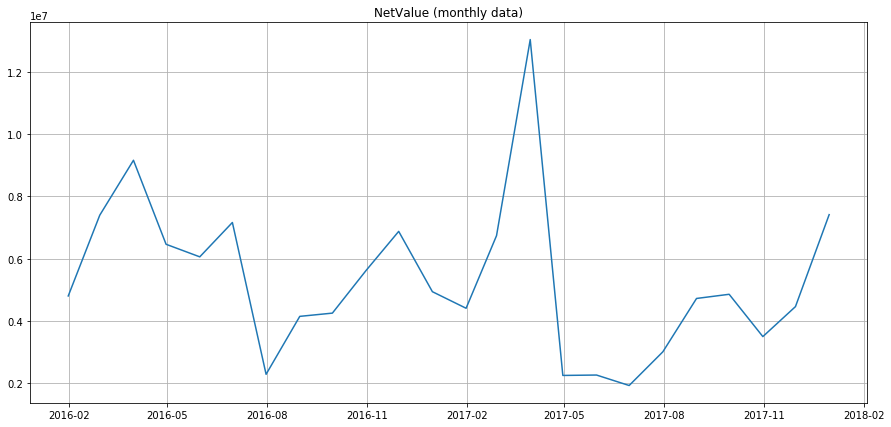

In [164]:
plt.figure(figsize=(15, 7))
plt.plot(data)
plt.title('NetValue (monthly data)')
plt.grid(True)
plt.show()

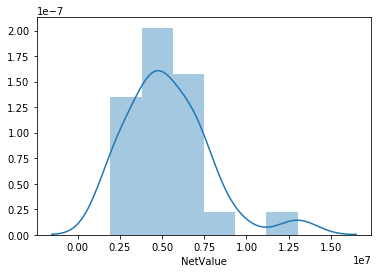

In [165]:
sns.distplot(data['NetValue']);

The above visualisations do indicate a stationarity in the series. Let us conduct Dickey Fuller test and check the rolling statistics just to be sure.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

##### Note that the signed values should be compared and not the absolute values.

In [166]:
# check stationarity by using rolling statistics and ADC test.
# Compare p-values to determine the stationarity of the data

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.NetValue.rolling(window=2).mean()
    rolstd = timeseries.NetValue.rolling(window=2).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15, 7))
    plt.grid(True)
    plt.plot(timeseries.NetValue,label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.NetValue, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #check the p value to determine whether the data is stationary or not
    if dfoutput['p-value'] > 0.05:
        print("NOT STATIONARY")
        print (dfoutput)
    else:
        print("STATIONARY")
        print (dfoutput)
    

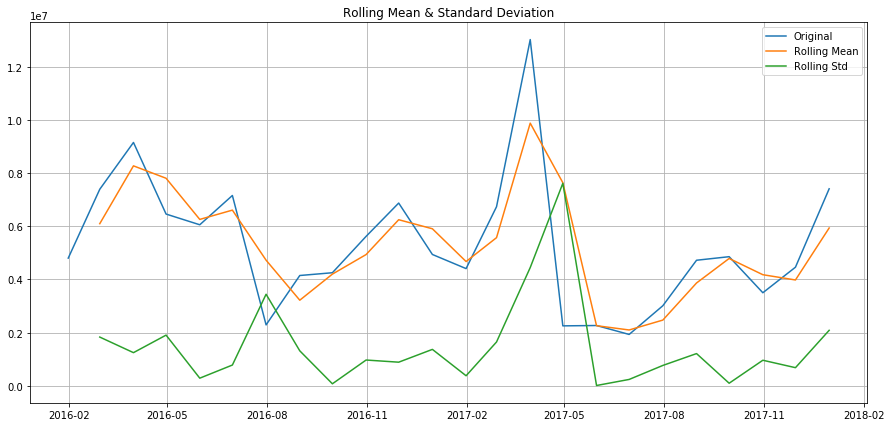

Results of Dickey-Fuller Test:
STATIONARY
Test Statistic                -3.6780
p-value                        0.0044
#Lags Used                     0.0000
Number of Observations Used   23.0000
Critical Value (1%)           -3.7529
Critical Value (5%)           -2.9985
Critical Value (10%)          -2.6390
dtype: float64


In [167]:
test_stationarity(data)

The p-value is quite low which is a good indicator of the stationarity of the given time series

Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. 

<Figure size 432x288 with 0 Axes>

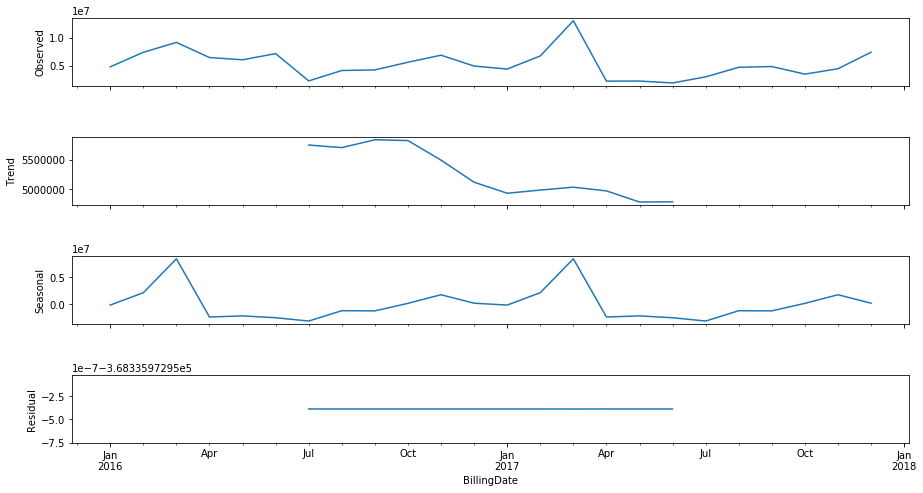

In [168]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data.NetValue, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


The above decomposition of the data indicates a strong seasonality.

If we split the 'Seasonal' plot at the end of Dec 2016 it can be observed that both parts are highly similar to each other. The pattern repeats itself after a year. This indicates seasonality over a period of a year or 12 months.

## HOLT - WINTERS METHOD
The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

Using Holt’s winter method will be the best option among the rest of the models beacuse of the seasonality factor. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.

![Image](../home/prerna/ShepHertz/PYTHON/eq.png?raw=true)

where s is the length of the seasonal cycle, for 0 ≤ α ≤ 1, 0 ≤ β ≤ 1 and 0 ≤ γ ≤ 1.

The level equation shows a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time t. The trend equation is identical to Holt’s linear method. The seasonal equation shows a weighted average between the current seasonal index, and the seasonal index of the same season last year (i.e., s time periods ago).



In this method, we can implement both additive and multiplicative technique. The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

We choose a seasonal_period=12 for 12 months. Other parameters can be tuned as per the dataset. I have used default parameters while building this model. You can tune the parameters to achieve a better model.

In [173]:

def holtwinter(data):

    train=data[0:-3]
    test=data[-3:]
    y_hat_avg_Holt_Winter = test.copy()
    from statsmodels.tsa.api import ExponentialSmoothing
    fit1 = ExponentialSmoothing(np.asarray(train['NetValue']) ,seasonal_periods=12,seasonal='mul').fit()
    y_hat_avg_Holt_Winter['Holt_Winter'] = fit1.forecast(len(test))
    # forecasting values for next 12 months
    y_hat_avg_Holt_Winter_pre = fit1.predict(start=25, end=37)
    rows = y_hat_avg_Holt_Winter_pre
    newDF = pd.DataFrame(columns=['NetValue'])
    date = pd.to_datetime(y_hat_avg_Holt_Winter.index.max(),format='%m-%Y' )
    # creating new dataset for future values
    for row in rows:
        import datetime
        monthNow = date.month + 1
        yearNow = date.year
        if monthNow > 12:
            monthNow = 1
            yearNow = date.year + 1
        date = datetime.date(yearNow, monthNow, 1)
        newDF.loc[date] = row
        
        date = pd.to_datetime(newDF.index.max(), format='%Y-%m-%d')
    # plotting train ,  test , prediction for test values and forecast for next 3 months
    plt.figure(figsize=(16,8))
    plt.plot(data, label = 'Data')
    plt.plot(newDF['NetValue'], label='Forecast')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    rms = np.sqrt(mean_squared_error(test.NetValue, y_hat_avg_Holt_Winter.Holt_Winter))
    pd.options.display.float_format = '{:.4f}'.format

    print(newDF)

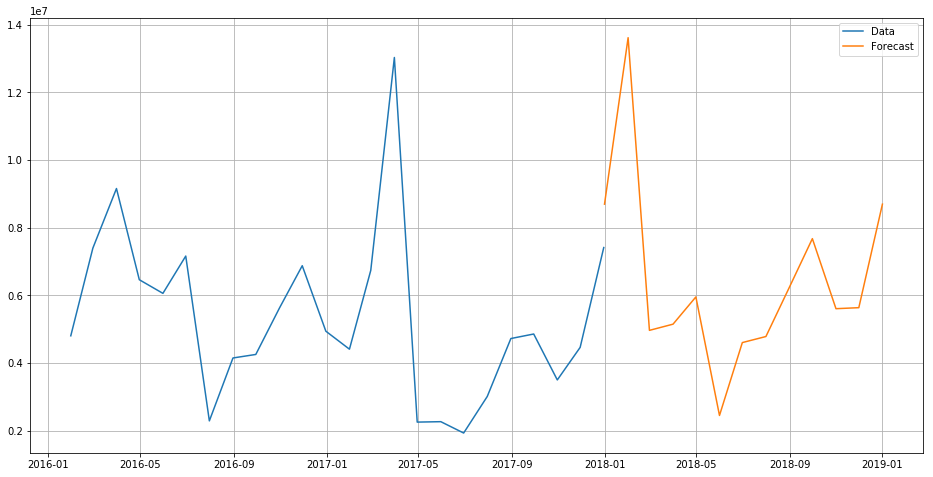

                NetValue
2018-01-01  8694836.5318
2018-02-01 13614864.6464
2018-03-01  4965480.3015
2018-04-01  5148559.0375
2018-05-01  5953857.3162
2018-06-01  2450372.8305
2018-07-01  4604182.3623
2018-08-01  4783483.0063
2018-09-01  6248375.5527
2018-10-01  7675926.7858
2018-11-01  5605730.6840
2018-12-01  5635741.3162
2019-01-01  8694836.5318


In [174]:
holtwinter(data)